[Markovify](https://github.com/jsvine/markovify) is one of the more elegant libraries I've come across. While it can be extended for general Markov Process use, it was written to generate novel sentences using Markov Chains on a corpus of text.

Its interface is extremely clean and astoundingly fast, fitting and predicting instantaneously

In [1]:
import re
import markovify


with open("Harry Potter and the Sorcerer.txt") as f:
    text = f.readlines()

    # drop chapter headings and blank lines
    text = [x for x in text if not x.isupper()]
    text = [x for x in text if x != "\n"]

model = markovify.Text(text)

for _ in range(5):
    print(model.make_sentence(), '\n')
print('--'*10)
for _ in range(5):
    print(model.make_sentence_with_start('Snape'), '\n')

So if I look in the setting sun. 

Where there should have let it fall open. 

There was no reason for not wanting Snape near him and Mrs. Weasley smiled down at the other boys. 

He clicked it again in Ron's eyes, but Harry, instead of looking up at once. 

Professor McGonagall had reached a fork in the same room, while Aunt Petunia and Uncle Vernon went off to look at him. 

--------------------
Snape gave Harry a nasty grin on his face. 

Snape was still rising higher and higher, and started pulling them off anyway. 

Snape was trying to look on Malfoy's face during the next table, wasn't having much more luck. 

Snape bent over the points they'd lost. 

Snape was in a large silver key that had just chimed midnight when the owls flooded into the classroom. 



I'm not going to go into the straight-up regex wizardry (heh) that the library employs to parse and validate all of the text. Instead, I want to peel back the curtain a bit and show how the library constructs the underlying Markov Chain and subsequently uses it to generate new sentences.

But first, a motivating example.

### Text and Markov Chains

The basic idea of Markov Chains and text is that you get a corpus of text

In [2]:
import re


example = ('Space: the final frontier. These are the voyages of the starship Enterprise. '
           'Its five-year mission: to explore strange new worlds. '
           'To seek out new life and new civilizations. '
           'To boldly go where no man has gone before!')
example = example.lower()
example = re.sub(r'[^\w\s]', '', example)
example = example.split(' ')
print(example)

['space', 'the', 'final', 'frontier', 'these', 'are', 'the', 'voyages', 'of', 'the', 'starship', 'enterprise', 'its', 'fiveyear', 'mission', 'to', 'explore', 'strange', 'new', 'worlds', 'to', 'seek', 'out', 'new', 'life', 'and', 'new', 'civilizations', 'to', 'boldly', 'go', 'where', 'no', 'man', 'has', 'gone', 'before']


and build a parser that will scan through the text, one pair at a time

In [3]:
for idx in range(len(example)-1):
    print(example[idx], example[idx+1])

space the
the final
final frontier
frontier these
these are
are the
the voyages
voyages of
of the
the starship
starship enterprise
enterprise its
its fiveyear
fiveyear mission
mission to
to explore
explore strange
strange new
new worlds
worlds to
to seek
seek out
out new
new life
life and
and new
new civilizations
civilizations to
to boldly
boldly go
go where
where no
no man
man has
has gone
gone before


More-accurately, you want to build a dictionary of key=word with values as a list of all words that have followed that keyword.

In [4]:
d = {}
for idx in range(len(example)-1):
    word = example[idx]
    new_word = example[idx+1]
    if word not in d:
        d[word] = [new_word]
    else:
        d[word].append(new_word)

print(d)

{'space': ['the'], 'the': ['final', 'voyages', 'starship'], 'final': ['frontier'], 'frontier': ['these'], 'these': ['are'], 'are': ['the'], 'voyages': ['of'], 'of': ['the'], 'starship': ['enterprise'], 'enterprise': ['its'], 'its': ['fiveyear'], 'fiveyear': ['mission'], 'mission': ['to'], 'to': ['explore', 'seek', 'boldly'], 'explore': ['strange'], 'strange': ['new'], 'new': ['worlds', 'life', 'civilizations'], 'worlds': ['to'], 'seek': ['out'], 'out': ['new'], 'life': ['and'], 'and': ['new'], 'civilizations': ['to'], 'boldly': ['go'], 'go': ['where'], 'where': ['no'], 'no': ['man'], 'man': ['has'], 'has': ['gone'], 'gone': ['before']}


So in this case, there's some repetition after the words `the` (the final, the voyages, the starship) and similarly for `to` (to explore, to seek, to boldly).

And so we can use this dictionary to reconstruct new phrases by following the keys. Let's say that we start with `mission`

In [5]:
d['mission']

['to']

then we follow that key and see that there are 3 different paths that we can go down

In [6]:
d['to']

['explore', 'seek', 'boldly']

the model will randomly select one of these, but for simplicity, we'll use `explore`

In [7]:
d['explore']

['strange']

In [8]:
d['strange']

['new']

And find another fork

In [9]:
d['new']

['worlds', 'life', 'civilizations']

In [10]:
d['life']

['and']

In [11]:
d['and']

['new']

it's easy to see how you can get caught up in a loop here.

In [12]:
d['new']

['worlds', 'life', 'civilizations']

But this goes on until we happen upon the last word in the phrase, `before`

In [13]:
d.get('before')

#### Couple caveats to this

* In practice, most implementations use *pairs of words* as their keys so capture more authentic-sounding phrases
* The list of words is appended with a couple sentinel values denoting beginning and end of the list. This way, the dictionary lookup terminates when it sees the end of the sequence, as opposed to the messy `dict.get()` that we did above.

That out of the way, let's return to the implementation.

### Model Fit

At the time that we instantiated a `markovify.Text` object a flurry of data processing happened to build a (Markov) `Chain` object that lives within our `Text` object, `model`.

#### Text Pre-pocessing

Hand-waving past all of this, I'll just say that there's a lot of care to remove weird quotes and characters, and figure out how to split the entire body of text into a neat list of sentences. Then within those lists, split the sentences by word.

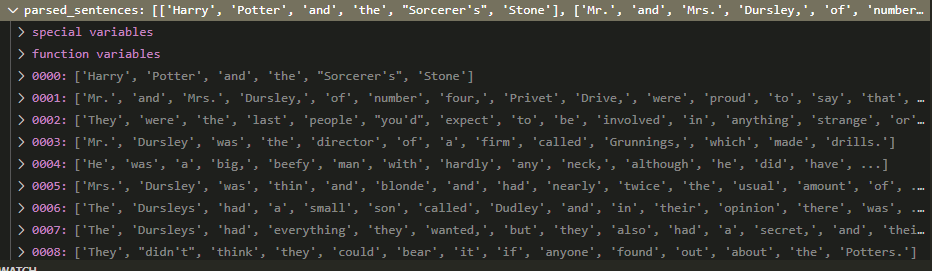

In [14]:
from IPython.display import Image

Image('images/parsed_sentences.PNG')

### `Chain`

Once we have the corpus worked out, we move onto the meat-and-potatoes object.

In the `.build()` method of the `Chain` object, we loop through all of our sentences, repeating the exercise that we did in our motivating example above.

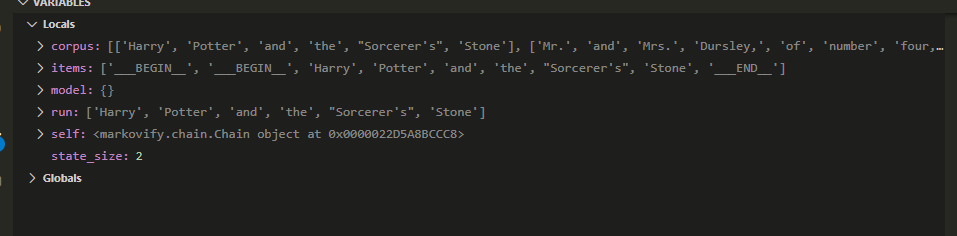

In [15]:
Image('images/build.PNG')

Fast-forwarding a bit and we're starting to see some patterns emerge. It's worth highlighting that our model's `state_size` is `2`, and so we're using *pairs of words* as our keys. Thus, values for the tuple (`__BEGIN__`, `__BEGIN__`) represent words that start sentences and tuples like (`__BEGIN__`, `Harry`) correspond to sentences that started with the word 'Harry'

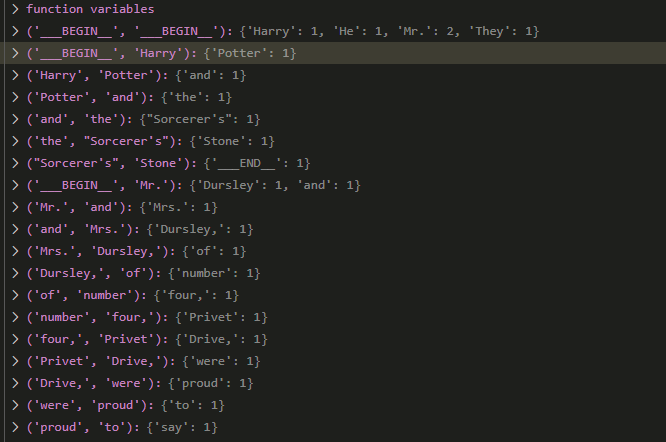

In [16]:
Image('images/ffwd.PNG')

### Clever construction of first values

So there are a finite number of sentence starts found in the book. Under the hood, all of their lists are constructed as `[__BEGIN__, __BEGIN__, <WORDS>, __END__]`.

So we start off by taking all of the words found in `model[('__BEGIN__', '__BEGIN__')]`, as well as all of their counts.

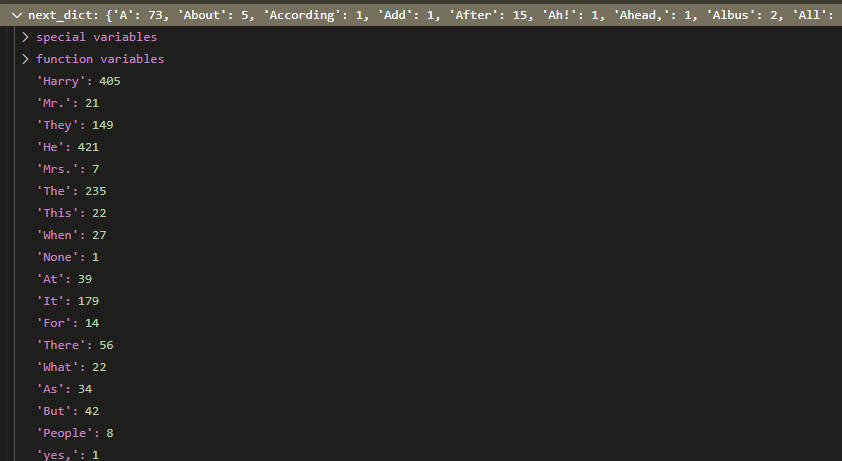

In [17]:
Image('images/next_dict.PNG')

Then, because we want our model to start sentences with words and phrases proportional to their appearance in the corpus, we do some clever sampling.

Using the dictionary above, we attach two lists to our `Chain` object: `choices` (the words) and `cumdist` (the cumulative sum of their counts).

### Building Sentences

Then, when we make calls to `model.make_sentence()` we sample from this cumulative distribution. Concretely, we take the last value in `cumdist` (the total number of values available) and sample randomly between `0` and that value.

Randomly running it as I type this, I got the following

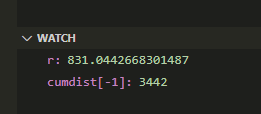

In [18]:
Image('images/sample.PNG')

then the library uses a really cool standard library called `bisect`, which essentially allows you to pass a float key as a list index, and it will round your input to the closest valid key. For example, the following code gives us the index of the value directly above our input float

In [19]:
from bisect import bisect

a = [0, 1, 2, 3, 4, 5]
bisect(a, 1.5)

2

So the value `r=831.044` yields the word `He`

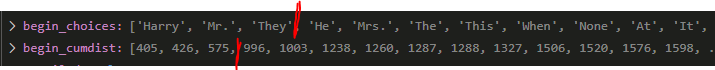

In [20]:
Image('images/first_value.PNG')

We repeat the process, tossing it back into the dictionary (as (`__BEGIN__`, `He`)) and find a follow-up word, `couldn't`. Then find another list of choices and their weights using (`He`, `couldn't`)

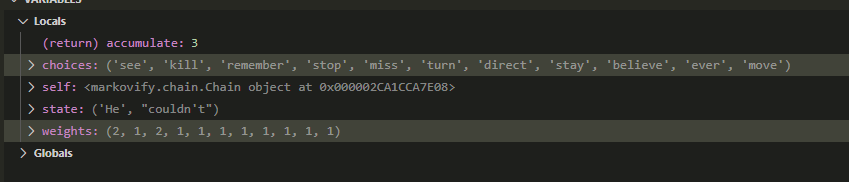

In [21]:
Image('images/choices.PNG')

We repeat this exercise until one of our dictionary lookups yields a `__END__` key, kicking us out. In this case, we arrive at that confusing, but valid, sentence `He couldn't direct it at the note.`

**Note**: As an added bonus, `markovify` does multiple runs for your initial keys to try and generate sentences with minimal overlap to our original corpus.